In [105]:
# Import library depdendencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [106]:
# Import flapping_fin_data
data = pd.read_csv("data/flutter_data_set.csv")

data.head()

,M,Vf,DC
0,0.778,1.696,-0.091831
1,0.667,0.533,0.056686
2,0.750,0.900,0.006096
3,0.700,1.300,0.012506
4,0.667,1.216,0.045172


In [107]:
# Make new column: "FO" (flutter occurence) based on sign of DC
data["FO"] = (1 - data["DC"] / abs(data["DC"])) / 2
data.drop("DC", axis=1, inplace=True)

In [108]:
# Split X and y
y = data["FO"]
X = data.drop("FO", axis=1)

In [109]:
# Split train-test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Use logistic regression
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()

lgr.fit(X_train, y_train)

y_pred_lgr = lgr.predict(X_test)

In [111]:
lgr.coef_

array([[2.79694654, 2.17123996]])

In [112]:
# Scale the input data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Create new a knn model
knn2 = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Use GridSearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)

# Fit model to data
knn_gscv.fit(X, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [114]:
knn_gscv.best_params_["n_neighbors"]

4

In [115]:
# Use KNN classifier
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_["n_neighbors"])

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

In [116]:
# Check score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy_lgr = accuracy_score(y_test, y_pred_lgr)
f1_lgr = f1_score(y_test, y_pred_lgr)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

scores = pd.DataFrame({
    "Model": ("LGR", "LGR", "KNN", "KNN"),
    "Score": ("Accuracy", "F1", "Accuracy", "F1"),
    "Value": (accuracy_lgr, f1_lgr, accuracy_knn, f1_knn)
})

In [117]:
scores.set_index(["Model", "Score"], inplace=True)

In [118]:
scores

Value
Model Score             
LGR   Accuracy  0.716667
      F1        0.653061
KNN   Accuracy  0.950000
      F1        0.938776

<Axes: >

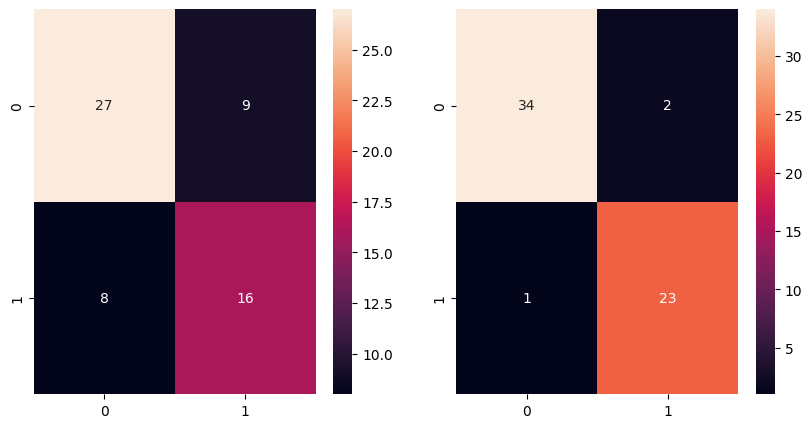

In [119]:
# Draw the confusion matrix
from sklearn.metrics import confusion_matrix

cm_lgr = confusion_matrix(y_test, y_pred_lgr)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(cm_lgr, annot=True, fmt='d', ax=ax[0])
sns.heatmap(cm_knn, annot=True, fmt='d', ax=ax[1])

c:\Users\hafiz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


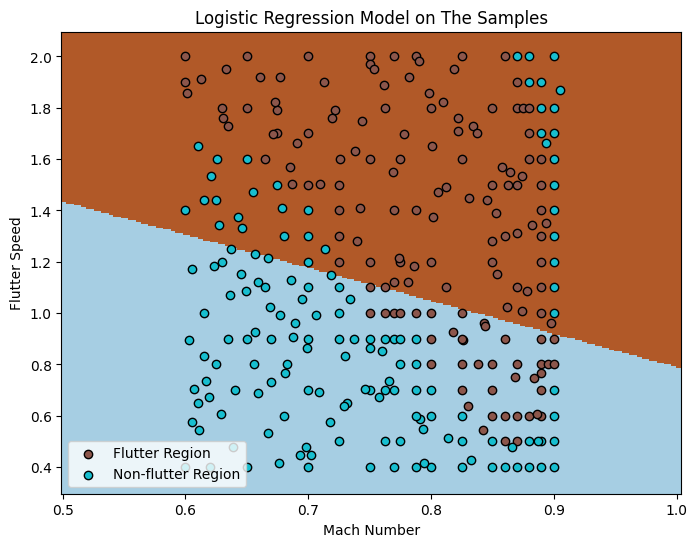

In [120]:
#Create the location of X to visualize
X1_min, X1_max = X['M'].min()-0.1, X['M'].max()+0.1
X2_min, X2_max = X['Vf'].min()-0.1, X['Vf'].max()+0.1

h1 = (X1_max-X1_min)/250
h2 = (X2_max-X2_min)/250

# Calculate prediction at each prediction location
XX1, XX2 = np.meshgrid(np.arange(X1_min, X1_max, h1), np.arange(X2_min, X2_max, h2))
X_norm = np.c_[XX1.ravel(), XX2.ravel()]

y = lgr.predict(X_norm)

# Put the result into a color plot
y = y.reshape(XX1.shape)

plt.figure(1, figsize=(8, 6))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(XX1, XX2, y)

flut = data.loc[data["FO"] == 1]
no_flut = data.loc[data["FO"] == 0]
plt.scatter(flut["M"],flut["Vf"],label='Flutter Region',c='tab:brown',edgecolors='k')
plt.scatter(no_flut["M"],no_flut["Vf"],label='Non-flutter Region',c='tab:cyan',edgecolors='k')

plt.xlabel('Mach Number')
plt.ylabel('Flutter Speed')

plt.title('Logistic Regression Model on The Samples')

plt.legend()

plt.show()

c:\Users\hafiz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


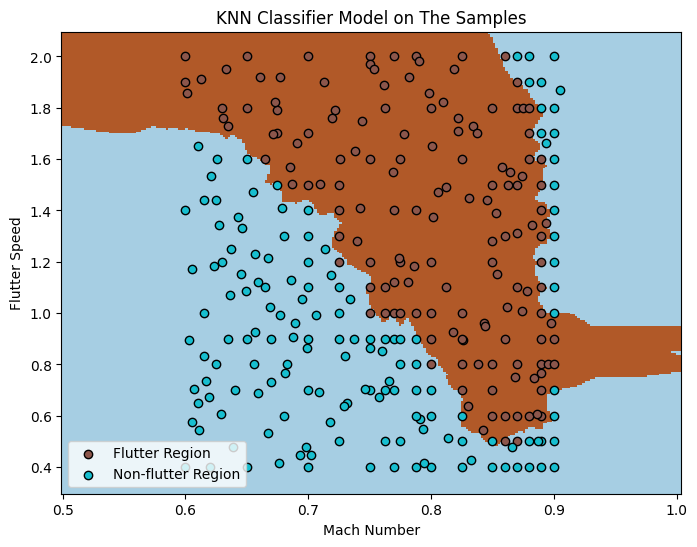

In [121]:
#Create the location of X to visualize
X1_min, X1_max = X['M'].min()-0.1, X['M'].max()+0.1
X2_min, X2_max = X['Vf'].min()-0.1, X['Vf'].max()+0.1

h1 = (X1_max-X1_min)/250
h2 = (X2_max-X2_min)/250

# Calculate prediction at each prediction location
XX1, XX2 = np.meshgrid(np.arange(X1_min, X1_max, h1), np.arange(X2_min, X2_max, h2))
X_norm = np.c_[XX1.ravel(), XX2.ravel()]

# Scale X for KNN model
scaler_X = MinMaxScaler()
scaler_X.fit(X)
X_norm = scaler_X.transform(X_norm)
y = knn.predict(X_norm)

# Put the result into a color plot
y = y.reshape(XX1.shape)

plt.figure(1, figsize=(8, 6))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(XX1, XX2, y)

flut = data.loc[data["FO"] == 1]
no_flut = data.loc[data["FO"] == 0]
plt.scatter(flut["M"],flut["Vf"],label='Flutter Region',c='tab:brown',edgecolors='k')
plt.scatter(no_flut["M"],no_flut["Vf"],label='Non-flutter Region',c='tab:cyan',edgecolors='k')

plt.xlabel('Mach Number')
plt.ylabel('Flutter Speed')

plt.title('KNN Classifier Model on The Samples')

plt.legend()

plt.show()